In [18]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [20]:
class TrafficSignCNN(torch.nn.Module):
    def __init__(self, num_classes=43):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(128 * 4 * 4, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Load model
model = TrafficSignCNN()
model.load_state_dict(torch.load("models/traffic_sign_cnn.pth", map_location="cpu"))
model.eval()

TrafficSignCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=43, bias=True)
)

In [21]:
def generate_gradcam(model, image_tensor, class_idx, target_layer='conv3'):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    layer = getattr(model, target_layer)
    handle_f = layer.register_forward_hook(forward_hook)
    handle_b = layer.register_backward_hook(backward_hook)

    image_tensor = image_tensor.unsqueeze(0)
    output = model(image_tensor)
    model.zero_grad()
    output[0, class_idx].backward()

    handle_f.remove()
    handle_b.remove()

    act = activations[0].squeeze().detach().numpy()
    grad = gradients[0].squeeze().detach().numpy()

    weights = np.mean(grad, axis=(1, 2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (32, 32))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

In [14]:
def generate_gradcam(model, image_tensor, class_idx, target_layer='conv3'):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    layer = getattr(model, target_layer)
    handle_f = layer.register_forward_hook(forward_hook)
    handle_b = layer.register_backward_hook(backward_hook)

    image_tensor = image_tensor.unsqueeze(0).to(DEVICE)
    output = model(image_tensor)
    model.zero_grad()
    output[0, class_idx].backward()

    handle_f.remove()
    handle_b.remove()

    act = activations[0].squeeze().cpu().detach().numpy()
    grad = gradients[0].squeeze().cpu().detach().numpy()
    weights = np.mean(grad, axis=(1, 2))

    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (32, 32))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam

In [22]:
# Choose a sample image
image_path = "data/train/14/00014_00000_00029.png"  # Example STOP sign

# Preprocess
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

image = Image.open(image_path).convert("RGB")
image_tensor = transform(image)

# True label (manually or via CSV)
true_label = 14


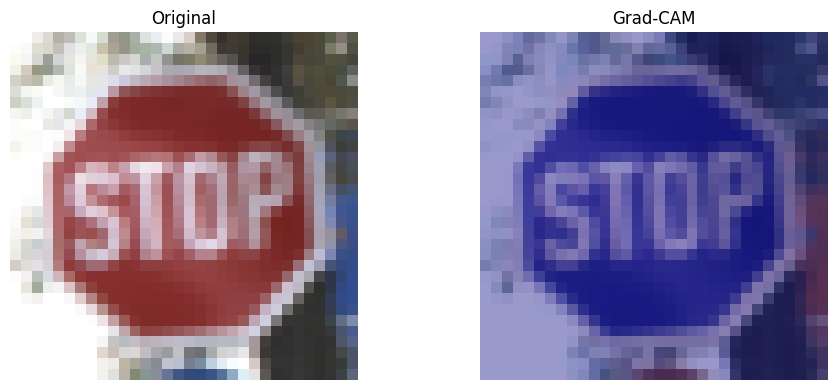

In [25]:
# Generate Grad-CAM
cam = generate_gradcam(model, image_tensor, class_idx=true_label)

# Unnormalize image
image_np = image_tensor.permute(1, 2, 0).numpy()
image_np = (image_np * 0.5 + 0.5).clip(0, 1)

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.uint8(image_np * 255), 0.6, heatmap, 0.4, 0)

# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay[:, :, ::-1])  # BGR to RGB
plt.title("Grad-CAM")
plt.axis("off")

# Save
os.makedirs("outputs", exist_ok=True)
plt.tight_layout()
plt.savefig("outputs/gradcam_sample_stop.png", dpi=200)
plt.show()